In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.animation import FuncAnimation

#%matplotlib nbagg
%matplotlib notebook
pd.set_option('display.max_rows', 100)

To predict the occurency of an eclipse we solve the N-body problem for the three bodies Earth, Moom and Sun.

In [2]:
def n_body_diff_eqs(t, r, ms, G=1):
    """
    Returns the differential equations to solve
    t: array-like
        Time interval to obtain the solution of the 
        differential equation.
        
    r: array-like
        Initial conditions of the differential equations.
        The length must be 6*N since for each body there
        must be 3 initial conditions for the position (x,
        y, z) and 3 for the velocity (vx, vy, vz).
        Then, r has the following structure r = [x1, y1,
        z1, vx1, vx2, vx3, x2, y2, z2, vx2, vy2, vz2,...]. 
        
    ms: array-like
        Array of length N containing the masses of the N
        bodies.
        
    G: float
        Universal gravitational constant. Default value is
        set to 1 due to the use of the canonical units. 
    """
    
    #Number of bodies. 
    n = 6
    N = int(len(r)/n)
    
    #Equations
    ecs = np.zeros(len(r))
    
    for i in range(N):
        dvdt_i = [0, 0, 0]
        
        for j in range(N):
            if i != j:
                d = np.sqrt((r[6*j+0]-r[6*i+0])**2 +
                            (r[6*j+1]-r[6*i+1])**2 +
                            (r[6*j+2]-r[6*i+2])**2 )
        
                for k in range(3):
                    #Acceleration dv/dt
                    dvdt_i[k] += G*ms[j]*( r[6*j+k] - r[6*i+k] ) / d**3
                    
        for l in range(3):
            ecs[6*i + l] = r[6*i + 3 + l]
            ecs[6*i + 3 + l] = dvdt_i[l] 
            
    return ecs


def plot_n_body_sol(sol, labels=False, draw_path=True, draw_init=True, draw_end=False, figsize=(9,9)):
    """
    Plots the solution of the N-body problem.
    sol: array-like
        Array of shape (len(ts), 6*N) containing the so-
        lution of the N-body problem.
        
    labels: bool/array-like
        If type is array-like then the array must content
        the names of the N bodies for which the problem 
        was solved.
    
    draw_path: bool
        Draw the path that each particule follows in the 
        time.
    
    draw_init: bool
        Draw the initial position of the N particles.
        
    draw_end: bool
        Draw the last position of the particule in the time
        of the simulation.
        
    figsize: tuple
        tuple containing the dimensions of the plot.
    """
    #Number of bodies
    N = int(sol.shape[1]/6)
    
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection="3d")
    font_label = {
            'family': 'serif',
            'weight': 'normal',
            'size': 8}
    
    font_label2 = {
            'family': 'serif',
            'weight': 'normal',
            'size': 10}
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
              '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    if np.array(labels).any:
        for i in range(N):
            if draw_path:    ax.plot(sol.T[6*i+0],     sol.T[6*i+1],     sol.T[6*i+2],    c=colors[i])
            if draw_end:  ax.scatter(sol.T[6*i+0][-1], sol.T[6*i+1][-1], sol.T[6*i+2][-1],c=colors[i], marker="o")
            if draw_init: ax.scatter(sol.T[6*i+0][0],  sol.T[6*i+1][0],  sol.T[6*i+2][0], c=colors[i], 
                                     label=labels[i], marker="o")

        plt.legend(loc="lower center", ncol=len(labels),
                   fancybox=True, shadow=True,
                   mode="expand",prop=font_label)

    else:
        for i in range(N):
            ax.plot(sol.T[6*i+0], sol.T[6*i+1], sol.T[6*i+2])
            ax.scatter(sol.T[6*i+0][0], sol.T[6*i+1][0], sol.T[6*i+2][0], "o")
    
    ax.set_xlabel("X [AU]", fontdict=font_label2)
    ax.set_ylabel("Y [AU]", fontdict=font_label2)
    ax.set_zlabel("Z [AU]", fontdict=font_label2)
    ax.set_zlim(ax.get_xlim())
    plt.tight_layout()
    plt.show()

# Units

In this notebook we are going to use canonical units. The unit of mass is the mass of the Sun, and we set, as usual, $G=1$. 

In [3]:
#Canonical units
m  = 1
km = 1000*m
kg = 1
s  = 1
G  = 6.67408e-11*m**3/kg/s**2

ul = 1.496e11*m
um = 1.9891e30*kg
ut = np.sqrt(ul**3/(G*um))
G  = 1

"""
ul = 384400*km
um = 5.9722e24*kg
ut = np.sqrt(ul**3/(G*um))
G  = 1
"""
 
print(f"unit of time   = {ut} s")
print(f"unit of mass   = {um} kg")
print(f"unit of length = {ul} m")

unit of time   = 5021961.483852004 s
unit of mass   = 1.9891e+30 kg
unit of length = 149600000000.0 m


# State vector SV and integration time

In [4]:
#Loading the data. https://ssd.jpl.nasa.gov/horizons/app.html#/
data = pd.read_csv("Moon_Earth_Sun_SV.csv", index_col="Body")
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" ", "_")

#Converting the units from km, kg and sec to ul, um and ut. And to datetime
data[["X", "Y", "Z"]]    = data[["X", "Y", "Z"]]*km/ul
data[["VX", "VY", "VZ"]] = data[["VX", "VY", "VZ"]]*km*ut/ul
data[["Mass"]] = data[["Mass"]]/um
data["Calendar_Date_(TDB)"] = pd.to_datetime(data["Calendar_Date_(TDB)"])
data

,Mass,JDTDB,Calendar_Date_(TDB),X,Y,Z,VX,VY,VZ
Body,,,,,,,,,
Moon,3.693969e-08,2460229.5,2023-10-12,0.938009,0.308118,0.000338,-0.332935,0.914780,-0.002456
Earth,3.002463e-06,2460229.5,2023-10-12,0.940640,0.307533,0.000188,-0.326358,0.946769,-0.000022
Sun,1.000000e+00,2460229.5,2023-10-12,-0.008335,-0.002305,0.000213,0.000240,-0.000452,-0.000002


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3 entries, Moon to Sun
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Mass                 3 non-null      float64       
 1   JDTDB                3 non-null      float64       
 2   Calendar_Date_(TDB)  3 non-null      datetime64[ns]
 3   X                    3 non-null      float64       
 4   Y                    3 non-null      float64       
 5   Z                    3 non-null      float64       
 6   VX                   3 non-null      float64       
 7   VY                   3 non-null      float64       
 8   VZ                   3 non-null      float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 240.0+ bytes


In [6]:
SV_MES = list(data.values[:,3:].flatten())
ms_MES = list(data["Mass"].values)

### Integration time

The main objective of this work is to predict the occurency of the eclipses in a [Saros]("https://eclipse.gsfc.nasa.gov/SEsaros/SEsaros.html") cycle of about $18$ years, so, we are goin to integrate in that period of time. 

In [7]:
t_min  = 0/ut
t_max  = 19*365.5*24*3600/ut
t_step = int(1e7)
ts_MES = np.linspace(t_min, t_max, t_step)

print(f"Start time = {t_min}\nEnd_time = {t_max}")
print(f"Each step is equal to {ut*(t_max-t_min)/t_step} seconds")

Start time = 0.0
End_time = 119.4761851378791
Each step is equal to 60.00048 seconds


# Integration

In [8]:
sol_MES = odeint(func=n_body_diff_eqs,
                 y0=SV_MES,
                 t=ts_MES,
                 args=(ms_MES,),
                 tfirst=True, 
                 full_output=1)

sol_MES[1]["message"]

'Integration successful.'

<IPython.core.display.Javascript object>


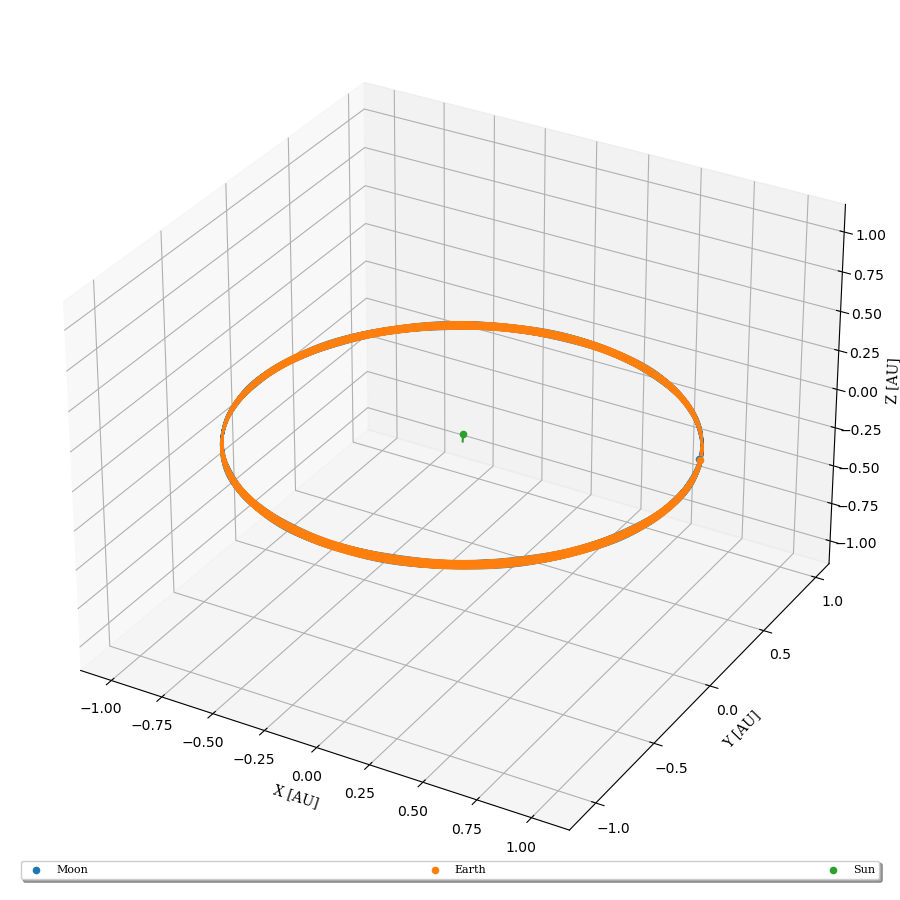

In [65]:
plot_n_body_sol(sol=sol_MES[0], labels=list(data.index.values))

# How to know if there is an eclipse?

Here we are going to use a geometric argument to establish whether we have an eclipse or not from the vectors of possition of the Moon, the Earth and the Sun. Lets say we have the possition vector for the Moon given by $\vec{R_{M}}=(x_M, y_M, z_M)$, for the Earth it is $\vec{R_{E}}=(x_E, y_E, z_E)$ and for the Sun we have $\vec{R_{S}}=(x_S, y_S, z_S)$. The vector that goes from Sun to Earth is given by:

\begin{equation}
    \vec{SE} = \vec{R_S} - \vec{R_E}
\end{equation}

and the vector that goes  from Earth to the Moon is given by

\begin{equation}
    \vec{EM} = \vec{R_E} - \vec{R_M}
\end{equation}

We would say that we have an eclipse if the magnitude of the cross product $\vec{SE}\times \vec{EM}$ is zero, but it is almost imposible to fullfill this condition, so we stablish a minimum tolerance value $\text{tol}$ for the croos product to determine if we have an eclipse:

\begin{equation}
    |\vec{SE}\times \vec{EM}| \leq \text{tol}
\end{equation}

It must be taken into account that as we are integrating in short time intervals, so we are going to get several times for a same eclipse, to group by those times and get the times for each single eclipse we use <code>DBSCAN</code> from Sklearn. 

In [9]:
# Possition vector for each, Moon, Earth and Sun
rs_Moon  = sol_MES[0][:,0:3]
rs_Earth = sol_MES[0][:,6:9]
rs_Sun   = sol_MES[0][:,12:15]

# SE and EM
SE_vector = rs_Sun - rs_Earth
EM_vector = rs_Earth - rs_Moon

mag_SEcrossEM = np.linalg.norm(np.cross(SE_vector, EM_vector), axis=1)
mag_SEcrossEM.shape, any(mag_SEcrossEM < 0)

((10000000,), False)

The min and max values for the magnitude of the cross product $\vec{SE}\times \vec{EM}$. From here we set the minimum tolerance $\text{tol}$ parammeter that is going to be used to determine whether we have an eclipse or not. 

In [10]:
min(mag_SEcrossEM), max(mag_SEcrossEM)

(1.0401338584584427e-07, 0.002743167388585199)

In [42]:
# the indexes for the times during integration
id_ts_MES = np.linspace(0, len(ts_MES)-1, len(ts_MES), dtype=int)

# Determining the indexes of times during eclipses
tol = 6.2e-5
id_eclipse_times = id_ts_MES[mag_SEcrossEM<tol]

# Total amount of times found during eclipses
print(f"{id_eclipse_times.shape[0]}")

21949


In [43]:
id_eclipse_times

array([   3798,    3799,    3800, ..., 9993238, 9993239, 9993240])

Here we use DBSCAN to group by the times of each single eclipse. The <code>max_dist</code> parammeter is used as a rule to stablish the maximum distance beetween two indexes (times) for a single eclipse. 

In [44]:
max_dist = 10
groups_DBSCAN =  DBSCAN(eps=max_dist, min_samples=max_dist).fit(id_eclipse_times.reshape(-1,1))

In [45]:
eclipse_groups = pd.DataFrame({"id_time":id_eclipse_times,
                               "eclipse_group":groups_DBSCAN.labels_
                              }
                             ).groupby("eclipse_group", as_index=False)

eclipse_groups.ngroups

83

In [46]:
# Function to sum an amount of time from a given timestamp
def sum_time(time,
             start=data["Calendar_Date_(TDB)"]["Moon"],
             unit="sec", ):
    return  start + pd.Timedelta(time, unit=unit)

print(f"The start time is {data['Calendar_Date_(TDB)']['Moon']}")

The start time is 2023-10-12 00:00:00


In [47]:
eclipses = pd.DataFrame(eclipse_groups.agg([
                                     ("eclipse_start_id", "min"),
                                     ("eclipse_end_id",   "max"),
                                     ("eclipse_start", lambda x:sum_time(ts_MES[min(x)]*ut) ),
                                     ("eclipse_end",   lambda x:sum_time(ts_MES[max(x)]*ut)),
                                     ("duration",      lambda x:(ts_MES[max(x)]-ts_MES[min(x)])*ut)
                                    ])
                       )

eclipses.columns = [eclipses.columns.values[i][0] if i==0 else eclipses.columns.values[i][1]
                    for i in range(eclipses.columns.values.shape[0])]

eclipses = eclipses.set_index("eclipse_group")
eclipses

,eclipse_start_id,eclipse_end_id,eclipse_start,eclipse_end,duration
eclipse_group,,,,,
0,3798,4124,2023-10-14 15:18:01.845828185,2023-10-14 20:44:02.004264200,19560.158436
1,24138,24376,2023-10-28 18:18:11.731069173,2023-10-28 22:16:11.846737185,14280.115668
2,237927,238167,2024-03-25 05:28:55.632533565,2024-03-25 09:28:55.749173576,14400.116640
3,258725,259017,2024-04-08 16:07:05.740362575,2024-04-08 20:59:05.882274589,17520.141912
4,492552,492775,2024-09-18 01:15:59.380295943,2024-09-18 04:58:59.488673955,13380.108378
5,513623,513957,2024-10-02 16:27:09.620802965,2024-10-02 22:01:09.783126980,20040.162324
6,747640,747975,2025-03-14 04:46:03.353076339,2025-03-14 10:21:03.515886359,20100.162810
7,769524,769729,2025-03-29 09:30:13.988701403,2025-03-29 12:55:14.088331416,12300.099630
8,1003200,1003504,2025-09-07 16:08:07.555248760,2025-09-07 21:12:07.702992782,18240.147744


In [48]:
eclipses.columns

Index(['eclipse_start_id', 'eclipse_end_id', 'eclipse_start', 'eclipse_end',
       'duration'],
      dtype='object')

### Eclipse type

If the magniude of $R_E  > R_M$ then we have a solar eclipse, otherwise a lunar eclipse.  

In [49]:
rs_Moon_mag  = np.linalg.norm(rs_Moon[eclipses["eclipse_start_id"].values],  axis=1) 
rs_Earth_mag = np.linalg.norm(rs_Earth[eclipses["eclipse_start_id"].values], axis=1) 

eclipses["type"] = rs_Earth_mag>rs_Moon_mag
eclipses["type"] = eclipses["type"].apply(lambda x: "solar" if x else "lunar")
eclipses

,eclipse_start_id,eclipse_end_id,eclipse_start,eclipse_end,duration,type
eclipse_group,,,,,,
0,3798,4124,2023-10-14 15:18:01.845828185,2023-10-14 20:44:02.004264200,19560.158436,solar
1,24138,24376,2023-10-28 18:18:11.731069173,2023-10-28 22:16:11.846737185,14280.115668,lunar
2,237927,238167,2024-03-25 05:28:55.632533565,2024-03-25 09:28:55.749173576,14400.116640,lunar
3,258725,259017,2024-04-08 16:07:05.740362575,2024-04-08 20:59:05.882274589,17520.141912,solar
4,492552,492775,2024-09-18 01:15:59.380295943,2024-09-18 04:58:59.488673955,13380.108378,lunar
5,513623,513957,2024-10-02 16:27:09.620802965,2024-10-02 22:01:09.783126980,20040.162324,solar
6,747640,747975,2025-03-14 04:46:03.353076339,2025-03-14 10:21:03.515886359,20100.162810,lunar
7,769524,769729,2025-03-29 09:30:13.988701403,2025-03-29 12:55:14.088331416,12300.099630,solar
8,1003200,1003504,2025-09-07 16:08:07.555248760,2025-09-07 21:12:07.702992782,18240.147744,lunar


In [51]:
eclipses.type.value_counts()

type
solar    42
lunar    41
Name: count, dtype: int64

# Saros cycle

The Saros cycle is a period of about 18 years and 10, 11, or 12 days used for astronomers since the Chaldean civilization to predict eclipses. In the following lines we plot it. [About Saros]("https://en.wikipedia.org/wiki/Saros_(astronomy)").

<IPython.core.display.Javascript object>


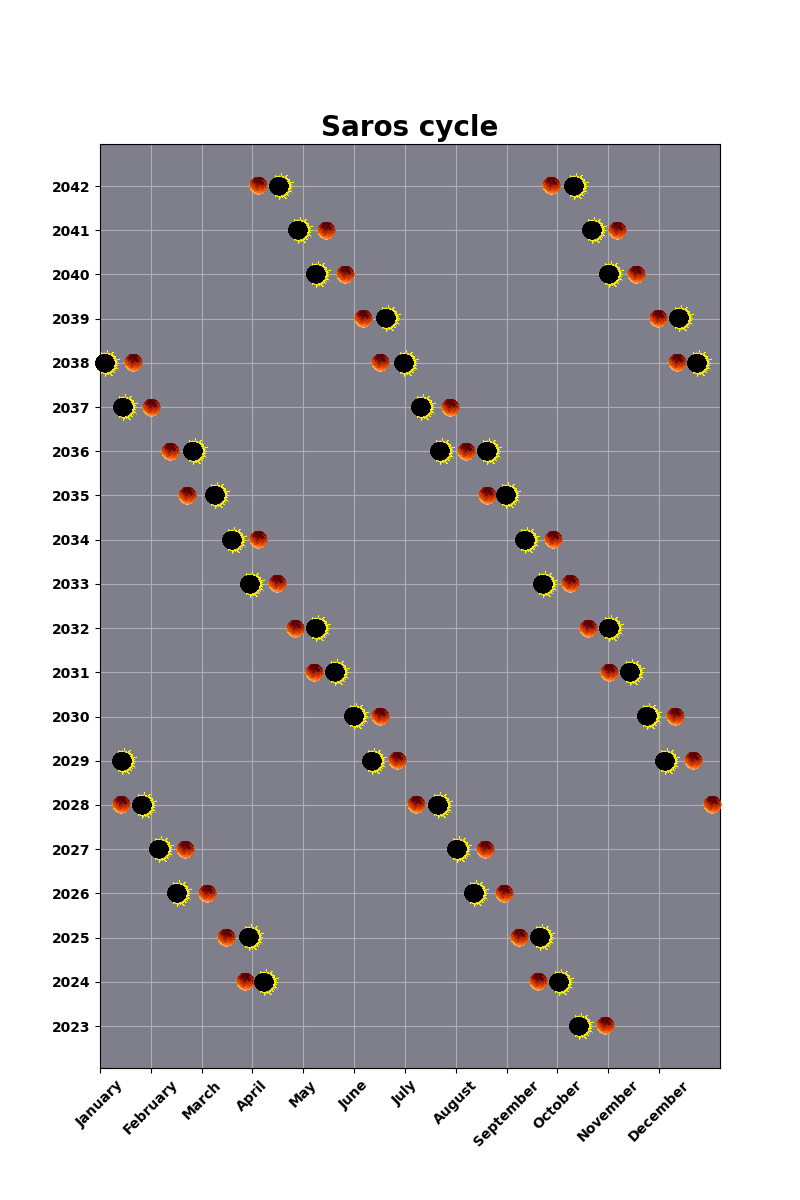

In [50]:
fig, ax = plt.subplots(figsize=(8, 12))


ax.scatter(x=eclipses["eclipse_start"].dt.month + eclipses["eclipse_start"].dt.day/30,
           y=eclipses["eclipse_start"].dt.year
           )

# Moon and Sun as markers
# https://stackoverflow.com/questions/22566284/matplotlib-how-to-plot-images-instead-of-points
#"""
def getImage(path, zoom=0.05):
    return OffsetImage(plt.imread(path), zoom=zoom)

for i in range(eclipses.shape[0]):
    if eclipses["type"][i]=="lunar": 
        path = "lunar.jpg"
        zoom = 0.06
    else:
        path = "solar.jpg"
        zoom = 0.04
        
    annotation = AnnotationBbox(getImage(path=path, zoom=zoom),
                                (eclipses["eclipse_start"].dt.month[i] + eclipses["eclipse_start"].dt.day[i]/30,
                                 eclipses["eclipse_start"].dt.year[i]),
                                frameon=False)
    ax.add_artist(annotation)
#"""

# custum
font_title = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 20}
ax.set_title("Saros cycle", **font_title)

font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 10}

ax.set_yticks(ticks=eclipses["eclipse_start"].dt.year.unique(), 
              labels=eclipses["eclipse_start"].dt.year.unique(), **font)

ax.set_xticks(ticks=np.linspace(1,12,12, dtype=int),
              labels=["January", "February", "March", "April",
                      "May", "June", "July", "August", "September",
                      "October", "November", "December"],
              rotation=45, **font)

ax.set_facecolor(np.array([127,127,140])/255)
ax.set(xlim=(1,13.2))
ax.grid()
plt.savefig("./saros.png")
plt.show()